# Movie 6

In [89]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2

movie6_path = "movies/movie6.avi"

## Functions for detecting edges

In [92]:
# Detect edges with OpenCV's findContours
# No longer used
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

# Detect edges by detecting the first occurrence of a minimum rectangular section where the mean pixel values exceeds a threshold
# Threshold differs for different movies

# check_section is used to calibrate and find the right parameters for a movie
def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

# Returns the left edge
def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

# Returns the right edge
def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

In [94]:
# This cell was used to generate frames used to calibrate and test parameters  
#movie_path = "movies/movie6.avi"
#output_path = "movies/movie6"
#movie = cv2.VideoCapture(movie_path)
#count = 0
#while movie.isOpened():
#    count += 1
#    success, frame = movie.read()
#    if not success:
#        break
#    cv2.imwrite(f'{output_path}/frame{count}.jpg', frame)

#movie.release()
#cv2.destroyAllWindows()

In [96]:
# from skimage import io
# img_raw = io.imread("movies/movie6/frame42.jpg")
# img = img_raw[18:110,:350]

# plt.imshow(img)

## Calibrate and estimate parameters for segments

### Algorithm to find left and right edges
- Break the grayed frame into a contibuous sequence of rectangles of width 'check_size'.
- Calculate mean pixel values of each rectangle
- Return the first rectangle whose mean pixel value exceeds the threshold value 'min_mean_pixel'

### Applying the algorithm
- The appropriate width of each edge is set to 40 for this movie.
- Some correction values may also be used to include all pixels at edges

In [99]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie6_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

frame_index = 0 # Track frame number for fluorescent intensity table

while True:
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to isolate region of interest
        canvas = frame[18:110,:350]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 20, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        edge_width = 10

        sections = check_sections(blur_frame, check_size=edge_width)
        for mean_pixel, position, width in sections:
            # print("Mean pixels:", mean_pixel)
            cv2.rectangle(canvas, (position,0), (position+width,canvas.shape[0]), (255, 255, 0), 1)
        
        left_side = get_left_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        
        left_side_thickness = 40
        right_side_thickness = 40
        left_side_offset_correction = 10
        right_side_offset_correction = 10

        # Left edge
        cv2.rectangle(canvas, (left_side,0), 
                              (left_side+left_side_thickness, canvas.shape[0]), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness,0), 
                              (right_side, canvas.shape[0]), 
                              (0, 0, 255), 1)

        # Entire cell
        cv2.rectangle(canvas, (left_side,0),
                             (right_side, canvas.shape[0]), 
                              (0, 255, 255), 1)

        cv2.imshow("Movie 6", canvas)


    # 1 frame per second
    if cv2.waitKey(500) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to end video


## Mean pixels at edge as fluorescent intensity values
- The mean pixel values obtained with 'cv2.mean()' are used as fluorescent intensity values
- Each value in each frame is appended to the 'fluorescent_intensities' list which will be converted to a Pandas dataframe for analysis
- The position of the trailing edge (left side) is also included to represent the position of the cell in each frame.
- The relative change in position will be used as displacement and for calculating velocity
- The time interval between each frame is 30 minutes.

In [104]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie6_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("output6.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0 # Track frame number for fluorescent intensity table

fluorescent_intensities = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = frame[18:110,:350]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 20, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        # Get trailing and leading bounding rectangle, and entire cell contour
        left_side = get_left_side(blur_frame, check_size=edge_width, min_mean_pixel=12)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=12)

        left_side_thickness = 40
        right_side_thickness = 40
        left_side_offset_correction = 10
        right_side_offset_correction = 10

        # Left edge
        cv2.rectangle(canvas, (left_side,0), 
                              (left_side+left_side_thickness, canvas.shape[0]), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness,0), 
                              (right_side, canvas.shape[0]), 
                              (0, 0, 255), 1)

        # Entire cell
        cv2.rectangle(canvas, (left_side,0),
                              (right_side, canvas.shape[0]), 
                              (0, 255, 255), 1)

        
        # Calculate mean intensity at trailing edge
        trailing_edge = gray_frame[0:canvas.shape[0], left_side:left_side+left_side_thickness]
        trailing_edge_intensity = cv2.mean(trailing_edge)
        #print("Trailing Edge:", trailing_edge_intensity)

        # Calculate mean intensity at leading edge
        leading_edge = gray_frame[0:canvas.shape[0], right_side-right_side_thickness:right_side]
        leading_edge_intensity = cv2.mean(leading_edge)
        #print("Leading Edge:", leading_edge_intensity)

        # Light stimulation occured at frame 42
        light_stimulated = False
        if frame_index >= 42:
            light_stimulated = True

        # Append intensity data to list
        fluorescent_intensities.append([frame_index, 
                                        trailing_edge_intensity[0], # Left edge
                                        leading_edge_intensity[0],  # Right edge
                                        (frame_index*30)-30,        # Time (30 minutes interval)
                                        right_side,                  # Cell position
                                        light_stimulated])          # Light stimulation applied?

        writer.write(canvas)

        cv2.imshow("Movie 6", canvas)

    else:
        break

    # 1 frame per second
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video


## Calculate Displacements and Velocities

In [107]:
intensity_dataframe = pd.DataFrame(fluorescent_intensities, columns =  ["Frame", "Trailing", "Leading", "Time", "Position", "Light Stimulated"])
# Displacement = All Positions - Starting position
intensity_dataframe["Displacement"] = intensity_dataframe["Position"] - intensity_dataframe["Position"][0]
# Time from minutes to seconds
intensity_dataframe["Time"] = intensity_dataframe["Time"] * 60
# Calculate velocity
# Velocity = displacement / time in seconds
intensity_dataframe["Displacement"].astype('float64')
intensity_dataframe["Time"].astype('float64')

intensity_dataframe["Average Velocity"] = intensity_dataframe["Displacement"] / intensity_dataframe["Time"]

instantaneous_distances = []
for idx in range(len(intensity_dataframe["Displacement"])):
    if idx > 0:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx]-intensity_dataframe["Displacement"][idx-1])
    else:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx])
        
intensity_dataframe["Instantaneous Displacement"] = pd.Series(instantaneous_distances)
intensity_dataframe["Instantaneous Velocity"] = intensity_dataframe["Instantaneous Displacement"] / 600

intensity_dataframe = intensity_dataframe.fillna(0)
intensity_dataframe

,Frame,Trailing,Leading,Time,Position,Light Stimulated,Displacement,Average Velocity,Instantaneous Displacement,Instantaneous Velocity
0,1,12.273913,15.392935,0,300,False,0,0.000000,0,0.0
1,2,11.964946,16.552717,1800,300,False,0,0.000000,0,0.0
2,3,11.548098,17.027717,3600,300,False,0,0.000000,0,0.0
3,4,11.393478,17.694837,5400,300,False,0,0.000000,0,0.0
4,5,11.180163,17.738043,7200,300,False,0,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...
60,61,12.734239,16.258967,108000,320,True,20,0.000185,0,0.0
61,62,12.750815,16.040761,109800,320,True,20,0.000182,0,0.0
62,63,12.727446,15.892935,111600,320,True,20,0.000179,0,0.0
63,64,13.159239,16.036957,113400,320,True,20,0.000176,0,0.0


## Plot fluorescent intensities

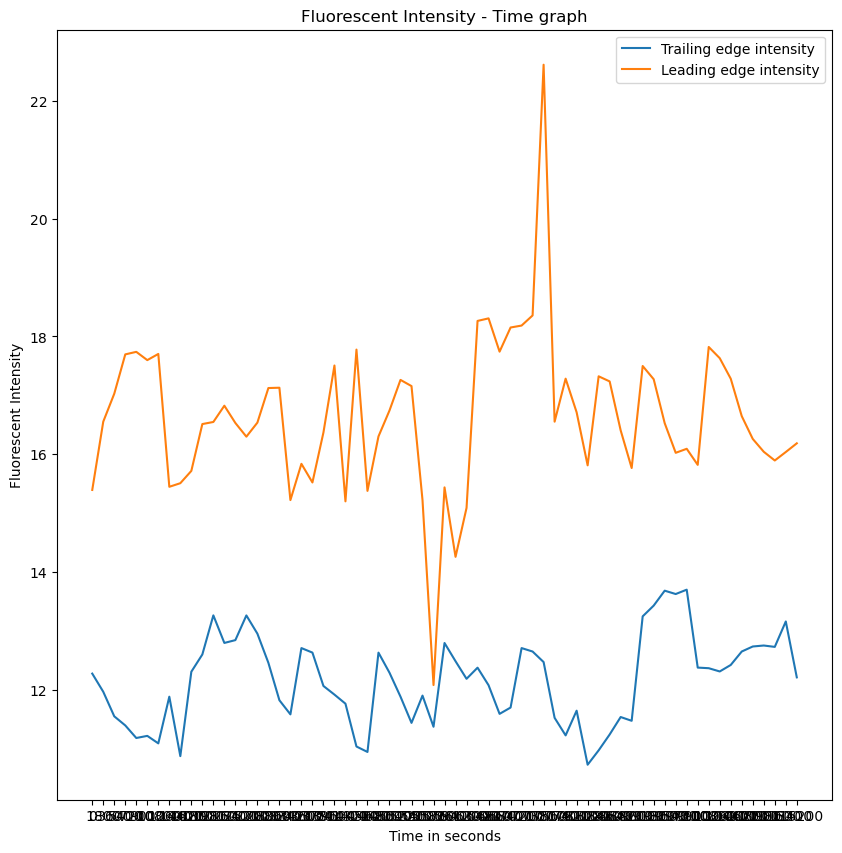

In [110]:
plt.figure(figsize=(10,10))
plt.plot(intensity_dataframe.Time, intensity_dataframe.Trailing, label="Trailing edge intensity")
plt.plot(intensity_dataframe.Time, intensity_dataframe.Leading, label="Leading edge intensity")

plt.title("Fluorescent Intensity - Time graph")
plt.ylabel("Fluorescent Intensity")
plt.xlabel("Time in seconds")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

## Comparison of intensities before and after light stimulation
- Since the visualization of fluorescent intensities do not seem to show an obvious difference, lets compare the mean intensity before and after light stimulation

In [113]:
light_stimulated_intensities = intensity_dataframe[intensity_dataframe['Light Stimulated'] == True]
not_light_stimulated_intensities = intensity_dataframe[intensity_dataframe['Light Stimulated'] == False]

<Axes: >

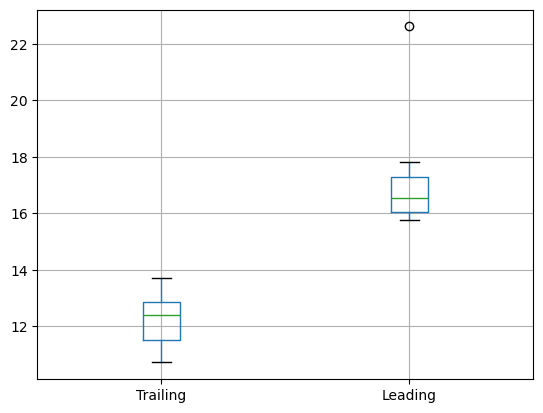

In [115]:
light_stimulated_intensities.boxplot(column=['Trailing','Leading'])

<Axes: >

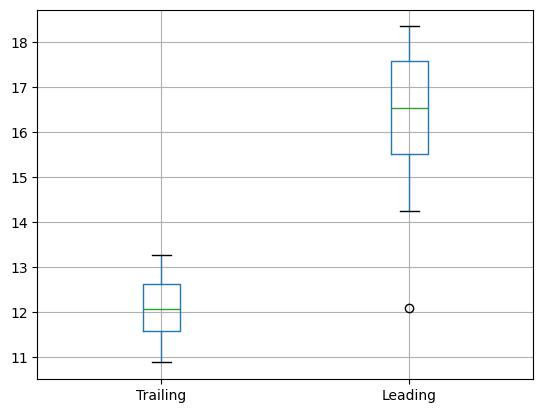

In [117]:
not_light_stimulated_intensities.boxplot(column=['Trailing','Leading'])

## ANOVA of intensities at leading (right) edge
- Since the leading edge (right side) intensity is the edge of interest in this particular case, lets perform an ANOVA test for both light stimulated and non-light stimulated frames

In [120]:
from scipy import stats
f, p = stats.f_oneway(not_light_stimulated_intensities['Leading'],light_stimulated_intensities['Leading'])
print(f,p)

1.0281363827403114 0.31447522972354075


## Non-significant Fluorescent intensity
- The ANOVA test score of 1.028 at P-value of 0.314 implies there is no significant difference between fluorescent intensity before and after light stimulation.
- Even though the movie shows an obvious aggregation at the leading (right) edge, the fluorescence in the imaging is well spread out such that calculated mean pixel values are similar. 

## Comparing displacements before and after light stimulation

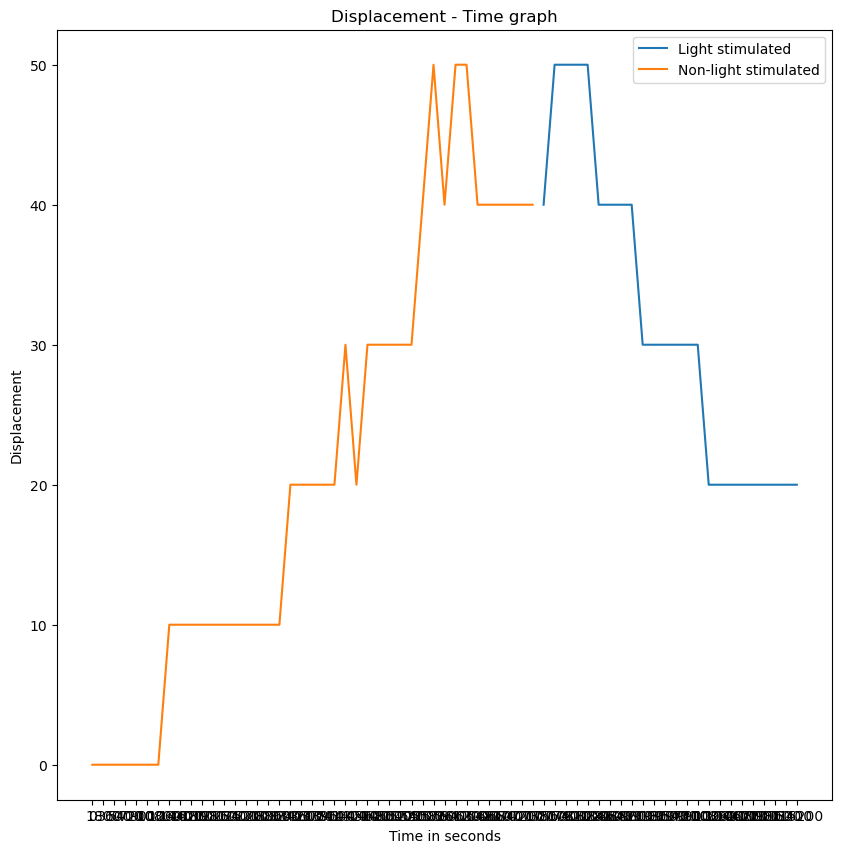

In [124]:
plt.figure(figsize=(10,10))
plt.plot(light_stimulated_intensities.Time, light_stimulated_intensities["Displacement"], label="Light stimulated")
plt.plot(not_light_stimulated_intensities.Time, not_light_stimulated_intensities["Displacement"], label="Non-light stimulated")

plt.title("Displacement - Time graph")
plt.ylabel("Displacement")
plt.xlabel("Time in seconds")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

## Light stimulation causes change in cell direction
- The graph above shows a reverse in displacement of cell upon light stimulation
- Light-induced upregulation of RhoA activity via optoGEF-RhoA/CAAX-CIBN-GFP17 at the leading edge of cells inside unconfined channels enriched SWELL1 localization and promoted a mesenchymal/protrusive to blebbing phenotypic switch followed by a reversal of migration direction